In [2]:
import pickle
sources = pickle.load(open('sources.p', 'rb'))

# Data Exploration

###  Dataset sizes

In [3]:
import os

def dir_size_and_count(folder):
    
    size = sum(os.path.getsize('%s/%s'% (folder,f)) for f in os.listdir(folder) if os.path.isfile('%s/%s'% (folder,f)))
    arr = [f for f in os.listdir(folder) if f.endswith('.png')]
    count = len(arr)
    return size, count

In [4]:
names = [f for f, _ in sources.iteritems()]
sizes = []
numimages = []
for key, _ in sources.iteritems():
    size, count = dir_size_and_count(sources[key]['folder'])
    size = '{0:,}'.format(size)
    sizes.append(size)
    numimages.append(count)

import pandas as pd
from pandas import DataFrame
d = {'sizes': sizes, 'images':numimages}
df = DataFrame(data=d, index=names) 
print df

       images        sizes
test    13068  356,832,724
train   33402  626,161,412


### Data visualization

Let's take a peek at some data from all three datasets, to make sure it looks sensible. 

In [5]:
import random, os
def pick_random_files(folder, n):
    files = []
    listdir = os.listdir(folder)
    for i in range(n):
        files.append(random.choice(listdir))
    return files

from IPython.display import display, Image
def display_image_file(filename):
    display(Image(filename)) 

Showing test source data


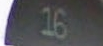

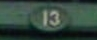

Showing train source data


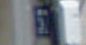

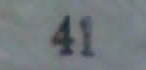

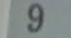

In [6]:
num_images = 3
for key, source in sources.iteritems():
    images = pick_random_files(source['folder'], num_images)
    print('Showing %s source data' % key)
    for image_filename in images:
        path = '%s/%s' % (source['folder'],image_filename)
        display_image_file(path)

It is important to notice that images may have different sizes. They could also be blurry, which is a case we want to accept for our classifier to learn.

## Image details

Additionally, we would like to understand what are the differences between the datasets provided.

In [7]:
from PIL import Image
import pandas as pd

def images_stats(path): 
    
    index = []
    widths = []
    heights = []
    
    for f in os.listdir(path):
        if not f.endswith('.png'):
            continue    
        with Image.open('%s/%s' % (path,f)) as im:
            width, height = im.size
            index.append(f.split('.')[0])
            widths.append(width)
            heights.append(height)
            
    data = {'width':widths, 'height': heights}
    df = pd.DataFrame(data, index=index)
    
    return df
        

In [8]:
for key, source in sources.iteritems():
    source['images_df'] = images_stats(source['folder'])
print 'done'

done


In [9]:
for key, source in sources.iteritems():
    print key
    print source['images_df'].max(), '\n'

test
height     516
width     1083
dtype: int64 

train
height    501
width     876
dtype: int64 



In [10]:
for key, source in sources.iteritems():
    print key
    print source['images_df'].min(), '\n'

test
height    13
width     31
dtype: int64 

train
height    12
width     25
dtype: int64 



In [11]:
for key, source in sources.iteritems():
    print key
    print source['images_df'].std(), '\n'

test
height     52.752352
width     122.586447
dtype: float64 

train
height    36.179696
width     80.546218
dtype: float64 



In [12]:
for key, source in sources.iteritems():
    print key
    print source['images_df'].mean(), '\n'

test
height     71.566498
width     172.583486
dtype: float64 

train
height     57.213011
width     128.284983
dtype: float64 



## Data details

In [13]:
import h5py

In [14]:
# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s
# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

# Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [15]:
import pandas as pd
from pandas import DataFrame
def image_labels_df(path):
    
    dsf = DigitStructFile('%s/digitStruct.mat' % (path))
    alldigit = dsf.getAllDigitStructure()

    names = []
    labels = []

    for number in alldigit:
        names.append(number['name'])
        labels.append(''.join(  ('0' if x==10.0 else str(int(x))) for x in number['label']))
    
    d = {'labels':labels}
    df = DataFrame(data=d, index=names)
    
    return df

In [16]:
for key, source in sources.iteritems():
    source['image_labels_df'] = None
    if key == 'extra':
        continue
    source['image_labels_df'] = image_labels_df(source['folder'])

In [18]:
from pandas import Series

1    2483
2    8356
3    2081
4     146
5       2
Name: digit_count, dtype: int64
1     5137
2    18130
3     8691
4     1434
5        9
6        1
Name: digit_count, dtype: int64


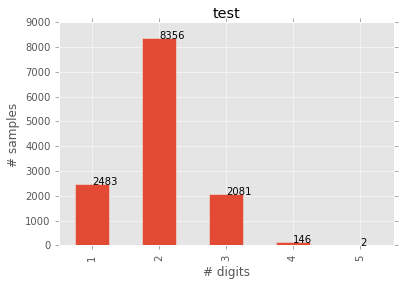

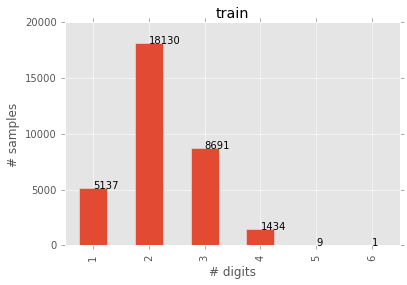

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


for key, source in sources.iteritems():
    df = source['image_labels_df']
    df['digit_count'] = df['labels'].str.len()
    digit_count = df['digit_count'].value_counts().sort_index()
    
    plt.figure()
    plt.title(key)
    plt.xlabel('# digits')
    plt.ylabel('# samples')

    for i, label in enumerate(list(digit_count.index)):
        score = digit_count.ix[label]
        plt.annotate(str(score), (i, score))
    
    print digit_count
    digit_count.plot(kind='bar')
    



In [20]:
import pickle
pickle.dump(sources, open('sources.p', 'wb'))